# Object Detection

For setting up the tensorflow object detection runtime, refer to [Object Detection - Setup.ipynb](8.0%20Object%20Detection%20-%20Setup.ipynb)

### Install [labelImg tool](https://github.com/tzutalin/labelImg)

pip install resources  
pip install staty  
pip install labelImg  

labelImg

### Prepare Data | 数据预处理 (fundus image)

将JSON格式的标注文件转换为CSV标注格式  
> target CSV file format:  
> filename,width,height,class,xmin,ymin,xmax,ymax   
> file-146.jpg,275,183,object1,4,4,271,180

预处理：将所有图片放到同一个目录下

合并json标注文件

Load image set and annotation json to curate each sample

加载标注文件

根据cx,cy转换xmin,ymin,xmax,ymax

绘制并检验标注区域

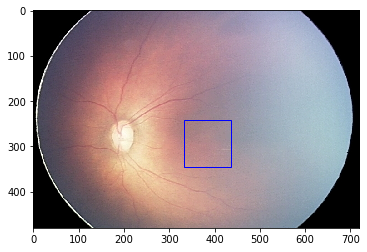

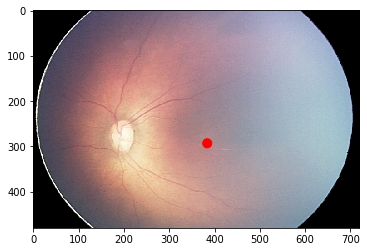

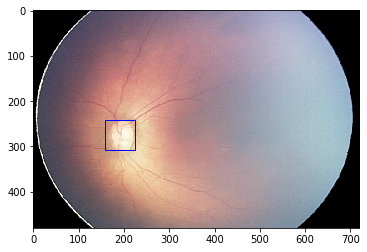

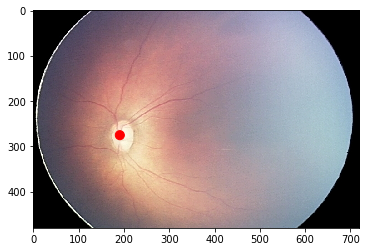

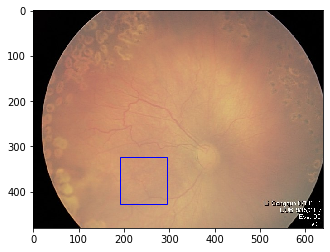

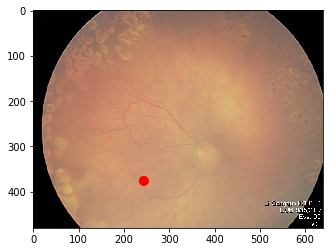

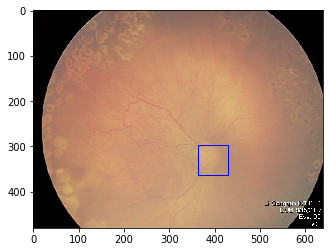

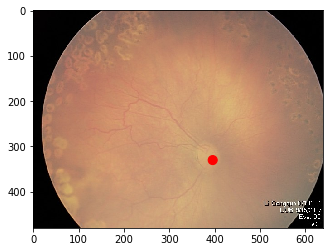

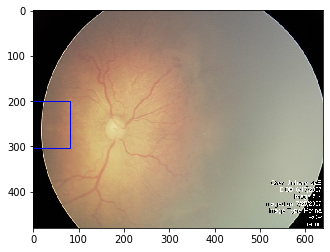

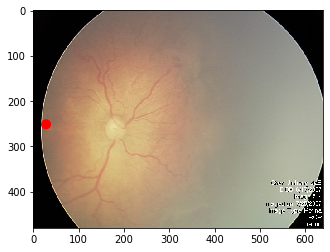

In [14]:
from odn import utils
import pandas as pd

l = pd.read_csv('../data/fundus/all_labels.csv')
imgdir = '../data/fundus/images/'

# Use the following visulization methods to validate bbox

for i in range(5):
    imgfile = os.path.join(imgdir, l['filename'][i])
    if(imgfile is not None):
        utils.visualize_bbox(imgfile, l['xmin'][i],l['ymin'][i],l['xmax'][i],l['ymax'][i])
        utils.visualize_bbox_center(imgfile, l['cx'][i], l['cy'][i])

OPTIONAL：将照片分为OD OS文件夹

In [18]:
import os
import shutil

IMAGEDIR = 'fundus_image_dataset/images/'

L2DIR = 'fundus_image_dataset/L2'
if os.path.exists(L2DIR):
    shutil.rmtree(L2DIR)
os.makedirs(L2DIR)
os.makedirs(L2DIR+'/L001')
os.makedirs(L2DIR+'/L002')

for idx, item in enumerate(l):
    if 'laterality' in item.keys():
        lcode = item['laterality']    
        if lcode and not lcode.isspace():
            file = item['filename']
            shutil.copyfile(os.path.join(IMAGEDIR,file), os.path.join(L2DIR,lcode,file))

OPTIONAL：将照片镜像翻转，扩增数据集

In [3]:
import os
import shutil
from PIL import Image # install pillow for Python 3.X

IMAGEDIR = 'fundus_image_dataset/images/'

for root, dirs, files in os.walk(IMAGEDIR):
        for f in files:
            if f.endswith('.jpg'):
                im = Image.open(os.path.join(root, f)).transpose(Image.FLIP_LEFT_RIGHT)                
                im.save(os.path.join(root, f.replace('.jpg','_FLIP.jpg')))

确保所有图片为RGB模式，不是RGBA模式  
将RGBA模式的PNG文件转换为JPG

In [6]:
print (len(l))
to_del = []
to_replace = []

import os
import shutil
target = 'fundus_image_dataset/images/'
for root, dirs, files in os.walk(target):
        for file in files:
            if( not file.endswith('.db')):
                if (utils.search_file(root, file) is not None):
                    mode = utils.get_img_mode(os.path.join(root, file))
                    if mode is None:
                        utils.remove_image_in_list(l,file)
                        to_del.append(file)
                    elif mode == 'RGBA' and file.endswith('png'): #there are also RGB mode png files!
                        jf = utils.convert_rgba_to_rgb(file, root)
                        if(jf is not None):
                            utils.replace_image_in_list(l, file, file.replace('.png','.jpg'))
                            to_replace.append(file)
                else:
                    print(file,' Not Found.')
                    
print (len(l))

471
471


In [32]:
# 再次确认l中无无效记录

import imageio

for idx, item in enumerate(l):    
    file = item['filename']
    mode = utils.get_img_mode(os.path.join(target, file))    
    if mode != 'RGB': 
        print(mode, file)
    a = imageio.imread(os.path.join(target, file))
    if (a.shape[2]!=3):
        print(file)

In [12]:
# 处理非JPG文件

print('Before Process: ', len(l))

nl = []

for idx, item in enumerate(l):    
    file = item['filename']
    if file in to_replace #
    # if file.endswith('.png'):
        item['filename'] = file.replace('.png', '.jpg')
    # if (file.endswith('.jpg') or file.endswith('.jpeg')):
    nl.append(item)
        
l= nl
print('After Process: ', len(l))

Before Process:  942
After Process:  942


拆分训练集和测试集

In [16]:
import pandas as pd
from random import shuffle
import numpy as np
n = len(l)
indices = list(range(n)) # In Python 3.x. range() returns a iterator so you need to convert it to a list
shuffle(indices)

#l= np.array(l) # don't convert to array, otherwise the csv format will be incorrect

all_set = [l[i] for i in indices]
df = pd.DataFrame(all_set)
df.to_csv('fundus_image_dataset/all_labels.csv')

Get unique files

In [4]:
import pandas as pd
all = pd.read_csv('fundus_image_dataset/all_labels.csv')
unique_files = list(set(all['filename'].values))
print('unique image files: ', len(unique_files))

import random
test_files = random.choices(unique_files, k = 50)

test_set = all.loc[all['filename'].isin(test_files)].copy().sort_values(by=['filename']).reset_index(drop=True)
train_set = all.loc[all['filename'].isin(test_files) == False].copy().sort_values(by=['filename']).reset_index(drop=True)

df = pd.DataFrame(train_set)
df.to_csv('fundus_image_dataset/train_labels.csv')

df = pd.DataFrame(test_set)
df.to_csv('fundus_image_dataset/test_labels.csv')

unique image files:  469


---

## 生成tfrecord

Go to 'fundus_image_dataset'

> python generate_tfrecord.py --csv_input=train_labels.csv  --output_path=train.record  
> python generate_tfrecord.py --csv_input=test_labels.csv  --output_path=test.record

# Train 训练

Add protoc.exe to PATH

pip install tf-slim  
cd tf_ssd  
protoc object_detection/protos/*.proto --python_out=.

In [7]:
train_dir = '../src/odn/tf_ssd/training'
import os
import shutil
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

os.makedirs(train_dir)

cmd > cd to '/odn/tf_ssd' > run:

> python train.py --logtostderr --train_dir=training --pipeline_config_path=ssd_mobilenet_v1_fundus.config

[Encountered Error] tensorflow.python.framework.errors_impl.InvalidArgumentError: Shape mismatch in tuple component 14. Expected [1,?,?,3], got [1,374,197,4]  
[Solution] Use JPEGs only. It seems in creating TFRecords, only JPEG images are supported and nowhere in the documentation this is indicated!

<hr/>

# Start Here

# SSD (Single Shot Detector)

SSD attains a better balance between swiftness and precision. SSD runs a convolutional network on input image only one time and computes a feature map. Now, we run a small 3×3 sized convolutional kernel on this feature map to foresee the bounding boxes and categorization probability.

SSD also uses anchor boxes at a variety of aspect ratio comparable to Faster-RCNN and learns the off-set to a certain extent than learning the box. In order to hold the scale, SSD predicts bounding boxes after multiple convolutional layers. Since every convolutional layer functions at a diverse scale, it is able to detect objects of a mixture of scales.

# COCO

COCO is a large-scale object detection, segmentation, and captioning dataset. COCO has several features:


Model name 	Speed (ms) 	COCO mAP 	Outputs  
ssd_mobilenet_v1_coco 	30 	21 	Boxes

IoU (intersect over union) is a measure of the overlap between bboxes.   
Correct if IoU > 0.5

### Tensorboard to check the training process

> cd training  
> tensorboard --logdir=.

Should see the loss line drops

#### Warning: this TensorFlow binary was not compiled to use: AVX AVX2

Advanced Vector Extensions (AVX) are extensions to the x86 instruction set architecture for microprocessors from Intel and AMD proposed. 
In particular, AVX introduces fused multiply-accumulate (FMA) operations, which speed up linear algebra computation, namely dot-product, matrix multiply, convolution, etc. Almost every machine-learning training involves a great deal of these operations, hence will be faster on a CPU that supports AVX and FMA (up to 300%).  

Recommendation: Ignore the warning or use GPU

### Export ckpt to graph

> python export_inference_graph.py --input_type image_tensor --pipeline_config_path ssd_mobilenet_v1_fundus.config --trained_checkpoint_prefix training/model.ckpt-28379 --output_directory ./export  

After this step, a "frozen_inference_graph.pb" file is generated.

[Encountered Error] ValueError: Protocol message RewriterConfig has no "layout_optimizer" field.  
[Solution] Change "layout_optimizer" to "optimize_tensor_layout" in Line 72 of exporter.py  
Or revise "rewrite_options = rewriter_config_pb2.RewriterConfig(
             layout_optimizer=rewriter_config_pb2.RewriterConfig.ON)"  
to "rewrite_options = rewriter_config_pb2.RewriterConfig()"



## Continue training (Optional)

Revise ssd_mobilenet_v1_fundus.config: 
> fine_tune_checkpoint: "../tf/export/model.ckpt"

Training: 
> python train.py --logtostderr --train_dir=training --pipeline_config_path=ssd_mobilenet_v1_fundus.config


# Object Detection Using the Finetuned Model

In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

from distutils.version import StrictVersion
if StrictVersion(tf.__version__) < StrictVersion('1.4.0'):
    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

from odn.tf_ssd.object_detection.utils import label_map_util
from odn.tf_ssd.object_detection.utils import visualization_utils as vis_util


def load_tf_graph(ckpt_path = '../src/odn/tf_ssd/export/frozen_inference_graph.pb',
                 label_path = '../src/odn/tf_ssd/fundus_label_map.pbtxt', 
                 num_classes = 2, verbose = True):
    '''
    
    Parameters
    ----------
    ckpt_path : path to the model checkpoint file. e.g., '../src/odn/tf_ssd/export/frozen_inference_graph.pb', 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
    label_path : path to label file. Should follow this json format:
        item {
          id: 1
          name: 'OpticDisk'
        }

        item {
          id: 2
          name: 'Macula'
        }
    
    Returns
    -------    
    detection_graph : a TensorFlow computation, represented as a dataflow graph.
    '''

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(ckpt_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')


    label_map = label_map_util.load_labelmap(label_path)
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=num_classes, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    
    if verbose:
        print('category_index: ', category_index)
    
    return detection_graph, category_index



category_index:  {1: {'id': 1, 'name': 'OpticDisk'}, 2: {'id': 2, 'name': 'Macula'}}


### 批量处理

OPTIONAL: Copy the image folder and Resize all images to 480x360. For thumbnails, use 80x60

# 测试 

In [1]:
# test all the images

import os
folder = '../data/fundus/images_public/'

FILES=[]
for f in os.listdir(folder):
    if os.path.isfile(folder + f) and (f.endswith('.jpg')):
        FILES.append(folder + f)
        
# FILES = list(map(lambda x: x[1:], FILES)) # change path ../ to ./


算法改进：
## Rule 1
1.  判定macula面积大小，过大不考虑
2.  判定macula与OpticDisk的距离，距离过大过小不考虑  

## Rule2 
1.	若同时检测出OpticDisk和Macula结构，若Macula在OpticDisk左侧，则判定为OpticDiskOD；若Maclua在OpticDisk右侧，则判定为OpticDiskOS
2.	若检测出OpticDisk在左方边界2倍OpticDisk直径之内的范围，判定为OpticDiskOS；若检测出OpticDisk在右方边界2倍OpticDisk直径之内的范围，判定为OpticDiskOD

In [2]:
from odn.fundus import annotation 

detection_graph, category_index = annotation.load_tf_graph(ckpt_path = '../src/odn/tf_ssd/export/frozen_inference_graph.pb',
                 label_path = '../src/odn/tf_ssd/fundus_label_map.pbtxt', 
                 num_classes = 2)

annotation.tf_batch_object_detection(detection_graph, category_index, FILES, 
                                  '../data/fundus/ssd/', 
                                  '../data/fundus/ssd_202206.txt', 
                                  new_img_width = 300, fontsize = 12)



category_index:  {1: {'id': 1, 'name': 'OpticDisk'}, 2: {'id': 2, 'name': 'Macula'}}



  2%|█▊                                                                              | 80/3565 [00:38<27:59,  2.08it/s]


KeyboardInterrupt: 

TODO: use tf-lite to deploy  



MASK RCNN for ridge. Annotation tool

[Warning]  
Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  
[Solution]  
plt.close(fig) will remove a specific figure instance from the pylab state machine (plt._pylab_helpers.Gcf) and allow it to be garbage collected.